Notebooks to reproduce SCENT Fig3a by Junxi, edited by Ana.

In [1]:
import pybedtools
pybedtools.helpers.set_bedtools_path(
    '/projects/zhanglab/users/ana/bedtools2/bin/')

## Step 1a: Load GTEx data and filter for fine-mapped variants with PIP > 0.2


In [2]:
import pandas as pd
# Step 1a: Load GTEx data and filter for fine-mapped variants with PIP > 0.2
gtex_file = '/projects/zhanglab/users/ana/multiome/validation/originals/CAVIAR_Results_v8_GTEx_LD_ALL_NOCUTOFF_with_Allele.txt.gz'
gtex_df = pd.read_csv(gtex_file, compression='gzip', sep='\t')

In [3]:
gtex_df['CHROM'] = 'chr' + gtex_df['CHROM'].astype(str) # added chr

In [4]:
gtex_df['gene'] = gtex_df.GENE.str.split('.',expand=True)[0] # added regular ensgid
# gtex_df['gene_prob'] = gtex_df.gene + ',' + gtex_df.Probability.astype(str) # add probs
# fine_mapped_variants = gtex_df[gtex_df['Probability'] > 0.2]
# gtex_bed = pybedtools.BedTool.from_dataframe(fine_mapped_variants[['CHROM', 'POS', 'POS', 'gene_prob']])

## Step 1b: mapping the hgnc_symbols to ensembl IDs

In [5]:
from biomart import BiomartServer

In [6]:
server = BiomartServer("http://www.ensembl.org/biomart")
# select the dataset
dataset = server.datasets['hsapiens_gene_ensembl']

In [7]:
# attributes to read
attributes_all = ['ensembl_gene_id','hgnc_symbol']

# obtain attributes and read
response = dataset.search({'attributes': attributes_all})
responses = response.raw.data.decode('ascii')

# develop a dictionary to map positions
gene_positions = {}
for line in responses.splitlines():                                              
    line = line.split('\t')
    gene_id = line[0] 
    gene_positions[gene_id] = line[1]

In [8]:
gtex_df['hgnc_symbol'] = gtex_df['gene'].map(gene_positions)

In [9]:
gtex_df['gene_prob'] = gtex_df.hgnc_symbol + ',' + gtex_df.Probability.astype(str) # add probs
fine_mapped_variants = gtex_df[gtex_df['Probability'] > 0.2]
gtex_bed = pybedtools.BedTool.from_dataframe(fine_mapped_variants[['CHROM', 'POS', 'POS', 'gene_prob']])

## Step 2: Load annotations and common variants

In [56]:
# Step 2: Load annotations
annotations_file = '/projects/zhanglab/users/ana/multiome/results/scent/paper_results/Arthritis-tissue_allqced_bootpkg_nopc_allCT.FDR0.10.txt.gz'
annotations_df = pd.read_csv(annotations_file,compression='gzip',sep='\t')

# # Parse peak regions
annotations_df[['CHROM', 'START', 'END']] = annotations_df['peak'].str.split('-',expand=True)

In [57]:
# Convert annotations to BED format
annotations_bed = pybedtools.BedTool.from_dataframe(annotations_df[['CHROM', 'START', 'END', 'gene']])
annotations_bed.head()

chr2	70086966	70087166	AAK1
 chr17	42964386	42964586	AARSD1
 chr4	56467473	56467673	AASDH
 chr9	104991691	104991891	ABCA1
 chr19	1251416	1251616	ABCA7
 chr7	151341553	151341753	ABCB8
 chr16	15590981	15591181	ABCC1
 chr4	145179600	145179800	ABCE1
 chr6	30544742	30544942	ABCF1
 chr6	30720898	30721098	ABCF1
 

In [6]:
#### signac #####
# annotations_df = pd.read_csv('/projects/zhanglab/users/ana/multiome/results/signac/signac_neatseq_links_edited.csv',index_col=0)
# annotations_df = annotations_df[annotations_df.qvalue < 0.1].copy()
# annotations_bed = pybedtools.BedTool.from_dataframe(annotations_df[['seqnames', 'start', 'end', 'gene']])

In [ ]:
genomes_df = pd.read_csv('/projects/zhanglab/users/ana/bedtools2/ana_bedfiles/gen_truth/hg38/commonsnps_hg38.bed',header=None, sep='\t')
genomes_df.columns = ['CHROM','START','END','rsid']

# annotations_bed = pybedtools.BedTool.from_dataframe(annotations_df.reset_index()[['chrom','start','end','gene']])
common_variants_bed = pybedtools.BedTool.from_dataframe(genomes_df)
common_variants_bed.head()

## Step 3: Precompute common variants in annotations

In [58]:
# Step 3: Precompute common variants in annotations
common_var_in_annot = common_variants_bed.intersect(annotations_bed, wa=True, wb=True)
common_var_in_annot = common_var_in_annot.to_dataframe(names=['CHROM', 'POS', 'POS2', 'CHROM_ANN', 'START_ANN', 'END_ANN', 'GENE_ANN'])
common_var_in_annot = common_var_in_annot.reset_index() # added
common_var_in_annot.columns = ['CHROM', 'POS', 'POS2', 'RSID', 'CHROM_ANN', 'START_ANN', 'END_ANN', 'GENE_ANN']
common_var_in_annot.head()

,CHROM,POS,POS2,RSID,CHROM_ANN,START_ANN,END_ANN,GENE_ANN
0,chr1,921177,921177,rs147866846,chr1,921133,921333,MXRA8
1,chr1,940387,940387,rs555840699,chr1,940339,940539,SAMD11
2,chr1,940390,940390,rs4970379,chr1,940339,940539,SAMD11
3,chr1,941767,941767,rs114982608,chr1,941705,941905,TNFRSF18
4,chr1,941767,941767,rs114982608,chr1,941705,941905,SAMD11


## Step 4: Generate a dataframe with the TSS for each gene

In [34]:
import ctar

In [ ]:
windows_df = ctar.data_loader.get_gene_coords(annotations_df,gene_col='gene',gene_id_type='hgnc_symbol')
windows_df.dropna(subset=['chr', 'start', 'end'],inplace=True)

windows_df['CIS_START'] = windows_df['start'].astype(int) - 500000
windows_df['CIS_START'] = windows_df['CIS_START'].clip(lower=0)  # Ensure CIS_START is not negative
windows_df['CIS_END'] = windows_df['end'].astype(int) + 500000
windowsdf_bed = pybedtools.BedTool.from_dataframe(
    windows_df[['chr', 'CIS_START', 'CIS_END', 'gene']]
)
windowsdf_bed.head()

## Step 5: Calculate enrichment

In [63]:
from tqdm import tqdm
enrichment_genei = []
for gene_i in tqdm(set(fine_mapped_variants.hgnc_symbol) & set(annotations_df.gene)): # changed hgnc_symbols to gene
    # causal variant linked to gene_i by CAVIAR
    finemap_subset = fine_mapped_variants[fine_mapped_variants['hgnc_symbol']==gene_i] #
    finemap_subset_bed = pybedtools.BedTool.from_dataframe(finemap_subset[['CHROM','POS','POS','gene_prob']])
    # within a peak (intersect)
    causal_var_in_annot = finemap_subset_bed.intersect(annotations_bed, wa=True, wb=True)
    causal_var_in_annot = causal_var_in_annot.to_dataframe(names=['CHROM', 'POS', 'POS2', 'GENE_PIP' ,'CHROM_ANN', 'START_ANN', 'END_ANN', 'GENE_ANN'])
    
    if len(causal_var_in_annot)==0:
        enrichment_genei.append(0)
        continue

    causal_var_in_annot[['GENE_FIN','PIP']] = causal_var_in_annot['GENE_PIP'].str.split(',',expand=True)
    causal_var_in_annot['PIP'] = causal_var_in_annot['PIP'].astype(float)
    
    # linked to the same gene by SCENT as in GTEx
    causal_var_in_annot = causal_var_in_annot[causal_var_in_annot['GENE_FIN']==causal_var_in_annot['GENE_ANN']]
    pip_causal_var_in_annot_genei = sum(causal_var_in_annot.PIP)
    
    # common_var_in_annot: 1000G variant in a peak
    num_common_var_in_annot_genei = len(common_var_in_annot[common_var_in_annot['GENE_ANN']==gene_i])
    
    if num_common_var_in_annot_genei == 0:
        enrichment_genei.append(0)
        continue
    
    numerator = pip_causal_var_in_annot_genei/num_common_var_in_annot_genei

    # causal_var: causal variants linked to gene_i by CAVIAR
    pip_causal_var_genei = sum(finemap_subset.Probability)

    # common_var_in_cis: any 1000G variant within +/- 500kb of gene_i
    gene = windows_df[windows_df['gene'] == gene_i]
    chrom = gene['chr'].tolist()[0] # int()
    start = gene['CIS_START'].tolist()[0]
    end = gene['CIS_END'].tolist()[0]
    common_var_in_cis = genomes_df[(genomes_df['CHROM']==chrom) & (genomes_df['START']>start) & (genomes_df['END']<end)]
    num_common_var_in_cis_genei = len(common_var_in_cis)
    if num_common_var_in_cis_genei == 0:
        continue
        
    denominator = pip_causal_var_genei/num_common_var_in_cis_genei
    
    enrichment_genei.append(numerator/denominator)

#Calculate overall enrichment score
overall_enrichment = sum(enrichment_genei) / len(enrichment_genei) if len(enrichment_genei) > 0 else float('nan')
print(f"Overall Enrichment: {overall_enrichment}")

100%|██████████| 7648/7648 [41:23<00:00,  3.08it/s]  

Overall Enrichment: 11.848383675427673


In [166]:
# TSS
# brain 4.24
# arthritis 9.59
# dogma 6.94
# NEAT 10.9
# NeurlIPS 8.73
# Pituary 6.69
# SHARE-seq 12.45
# PBMC 7.06


3.1259444353589907

In [ ]:
# Gene body overall enrichment w PIP
# brain 5.32
# arthritis 11.85
# dogma 8.70
# NEAT 12.45
# NeurlIPS 11.48
# Pituary 10.00
# SHARE-seq 16.47
# PBMC 8.71

In [ ]:
# Gene body - NEAT
# SCENT - 11.88
# Signac - 3.95

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_55255/1247219589.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Tissue', y='Enrichment', data=df, color='#56B4E9', ci=None)


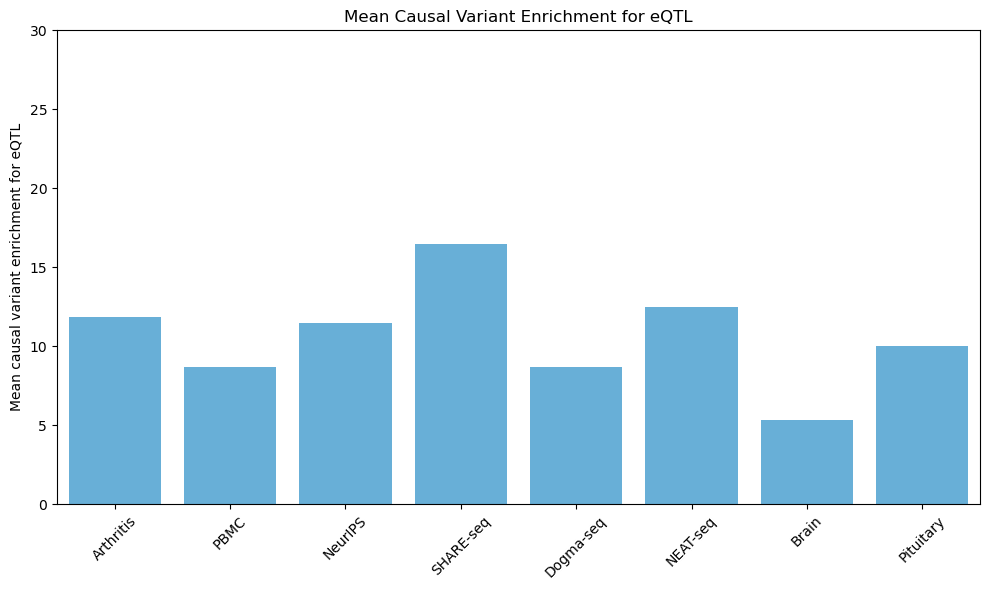

In [68]:
data = {
    'Tissue': ['Arthritis', 'PBMC', 'NeurIPS', 'SHARE-seq', 'Dogma-seq', 'NEAT-seq', 'Brain', 'Pituitary'],
    'Enrichment': [11.85, 8.71, 11.48, 16.47, 8.70, 12.45, 5.32, 10],
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Tissue', y='Enrichment', data=df, color='#56B4E9', ci=None)

# for i, value in enumerate(data['Enrichment']):
#     plt.errorbar(i, value, yerr=1, fmt='o', color='k')  

plt.ylim(0, 30)  # Set y-axis range to 0-30
plt.title('Mean Causal Variant Enrichment for eQTL')
plt.ylabel('Mean causal variant enrichment for eQTL')
plt.xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()